Celem zdania jest implementacja modelu regresji logistycznej trenowanego za pomocą algorytmu SGD z momentum. W zadaniu nauczyę model rozpoznawać ręcznie pisane cyfry pierwsze (2,3,5,7) od złożonych (4,6,8,9). Postaram się krok po kroku wyjaśnić jak działa mój model oraz jak dobierałem parametry uczenia aby uzsykać możliwie jak najwyższy wynik.

Importowanie niezbędnych bilbiotek.

In [1]:
import numpy as np
import random
from mlxtend.data import loadlocal_mnist
import matplotlib.pyplot as plt


Wczytanie danych. Plik ipynb musi znajdować się w tym samym folderze co zbiory dancyh.

In [2]:
x, y = loadlocal_mnist(images_path="train-images.idx3-ubyte"
                       ,labels_path="train-labels.idx1-ubyte" )
#Wczytanie danych treningowych, x zawiera artybuty ,natomiast y to zbiór cech

x_test, y_test = loadlocal_mnist(images_path="t10k-images.idx3-ubyte"
                       ,labels_path="t10k-labels.idx1-ubyte" )
#Wczytanie danych testowych,analogicznie x_test zawiera artybuty ,natomiast y_test to zbiór cech

Cyfry 0 i 1 nie interesują nas w danym problemie klasyfikacji, dlatego trzeba usunąć je ze wszystkich zbiorów.

In [3]:
result = np.where((y==0) | (y==1))#zmiena result zawiera indeksy liczb które są równe 0 lub 1
y = np.delete(y,result)#usunięcie danych z odpowiednimi indexami 
x = np.delete(x, result,axis = 0)

result = np.where((y_test==0) | (y_test==1)) #analogicznie dla zbioru testowego
y_test = np.delete(y_test,result)
x_test = np.delete(x_test, result,axis = 0)


Musimy podzielić zbiór na dwie klasy, liczby pierwsze (1) oraz liczby złożone (0). 

In [4]:
prime = [2,3,5,7]
notprime = [4,6,8,9]

for i in prime:
    y[y == i] = 1
    y_test[y_test == i] = 1
    #każda liczba pierwsza staje się jedynką
for i in notprime:
    y[y == i] = 0
    y_test[y_test == i] = 0
    #każda liczba złożona staje się zerem

Możemy zobaczyć, ile jest liczb pierwszych, a ile liczb złożonych w zbiorze treningowym.

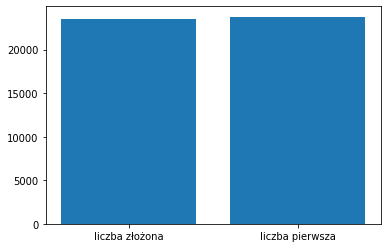

In [5]:
height = [len(y[y==0]),len(y[y==1])]
bars = ("liczba złożona", "liczba pierwsza")
y_pos = np.arange(len(bars))
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.show()

Jak widać jest ich praktycznie tyle samo.

In [6]:
print(height) # ile jest liczb pierwszych, a ile złożonych

[23560, 23775]


Teraz zaimplementuję model:

In [7]:
class Model(object):
    def __init__(self,x,y):
        self.x = x
        self.y = y
        self.N = x.shape[1]

    def fit(self,beta = 0.9, ler_rate = 0.01, epoch = 10000):
        self.theta = np.zeros((1, self.N)) # stworzenie wektora parametrów theta
        self.b = 0                         # wyraz wolny
        iteratrion = list(range(self.N))   # liczba iteracji 
        for i in range(epoch):
            
            grad_theta = np.zeros((1,self.N))  # wektor gradientów
            grad_b = 0                         # gradient wyrazu wolnego
            random.seed(i)                     # ustawienie tego samego ziarna dla każdej iteracji
            random.shuffle(iteratrion)         # przemieszanie danych 
            for j in iteratrion:
                prediction = np.dot(self.theta,x[j]) + self.b     # predykcja
                grad_theta = beta*grad_theta + ler_rate*((self.sigmoid(prediction) - y[j])*x[j]) #wykorzystanie poprzedniego gradnienu w celu przyspieszenia zbieżności (momentum)
                grad_b = beta*grad_b + ler_rate*(self.sigmoid(prediction) - y[j])

                self.theta = self.theta - grad_theta  #aktualizacja parametrów
                self.b = self.b - grad_b

    def sigmoid(self,x):      #funckja sigmoidalna, zapisana w inny sposób, aby uniknać problemów numerycznych
        if x >=0:
            z = np.exp(-x)
            return 1/(1 + z)
        else:
            z = np.exp(x)
            return z/(1 + z)




    def predict(self, X_test):                      #predykcja
        N = X_test.shape[0]
        self.predictions = np.zeros((1, N))

        for i in range(N):
            if self.sigmoid(np.dot(self.theta, X_test[i]) + self.b) > 0.5:  #klasyfikacja do odpowiedniej cechy na postawie wyniku funckji sigmoidalnej
                self.predictions[0][i] = 1
                
    @staticmethod
    def evaluate(Y_test, predictions):  #wyliczenie accuraccy
        N = Y_test.shape[0]
        correct = 0
        for i in range(N):
            if predictions[0][i] == Y_test[i]: 
                correct += 1
        accuracy =  correct / N
        return accuracy
    
    
    @staticmethod
    def confusion_matrix(Y_test, predictions):  #wyznaczenie macierzy błędu
        N = Y_test.shape[0]
        conf_matrix = np.zeros((2,2))

        for i in range(N):
            if predictions[0][i] == Y_test[i]:
                index = int(predictions[0][i])  #zakwalifikowanie wyniku jako prawdziwie pozytywne(PP) lub prawdziwie negatywne (PN)
                conf_matrix[index][index] +=1
            else:
                index = int(predictions[0][i]) #zakwalifikowanie wyniku jako fałszywie pozytywne (FP) lub fałszywie negatywne (FN)
                index2 = int(Y_test[i])
                conf_matrix[index][index2] +=1
        return conf_matrix


Możemy zainicjować model z danymi MNIST

In [8]:
regression = Model(x,y) #inicjacja regresji

In [9]:
regression.fit(epoch = 1000)
regression.predict(x_test)
pred = regression.predictions

print(regression.evaluate(y_test,pred))    #accuracy dla standardowych wartości learning rate i beta 

0.8525047558655675


Accuracy prezentuje się całkiem dobrze, jednak warto wybrać odpowiedni learning rate oraz parametr beta, aby uzsykać możliwe jak najlepszy wynik, aby  to sprawdzić zastosujemy prostą pętle:

In [10]:
all_posibility = np.linspace(0,1,25)    #stworzenie wektora z różnymi wartościami miedzy 0 a 1

In [11]:
accuracy_list = []                            #lista przechowuje accuracy dla konkretnej wartości learning rate 
for i in all_posibility:
    regression.fit(ler_rate = i, epoch = 10)   #trenowanie modelu dla konkretnego learning rate
    regression.predict(x_test)
    pred = regression.predictions 
    acc = regression.evaluate(y_test,pred)
    accuracy_list.append(acc)                  #zapisanie accuracy do listy

In [12]:
max_accuracy = max(accuracy_list)                #wyznaczenie największego accuraccy
lr_position = accuracy_list.index(max_accuracy)  
lr_max = all_posibility[lr_position]             #wyznaczenie wartości learning rate dla którego accuracy było największe 

Możemy przedstawić na wykresie jak accuracy zmieniało się wraz ze zmianą parametru learning rate.

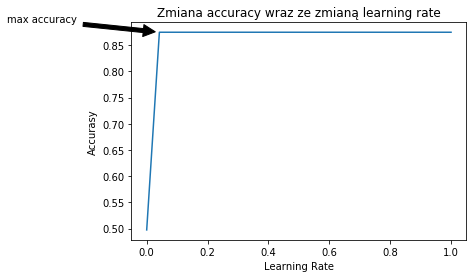

In [13]:
plt.figure()
plt.title("Zmiana accuracy wraz ze zmianą learning rate")
plt.plot(all_posibility, accuracy_list)
plt.annotate('max accuracy', xy=(lr_max, max_accuracy), xytext=(lr_max-0.5, max_accuracy +0.02),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel("Learning Rate")
plt.ylabel("Accurasy")
plt.show()

In [14]:
print(lr_max)

0.041666666666666664


Zaskakująco, według eksperymentów okazuje się, że learning rate nie ma w tym przypadku tak dużego znaczenia.
Powtórzymy eksperyment, tym razem próbując znaleźć najlepszy parametr beta.

In [15]:
beta_list = []  #lista zawierajaca accuracy dla każdej wartości beta
for i in all_posibility:
    regression.fit(epoch = 10, beta = i)  #analogiczne trenowanie modelu i zapisywanie accuracy
    regression.predict(x_test)
    pred = regression.predictions
    acc = regression.evaluate(y_test,pred)
    beta_list.append(acc)

In [16]:
max_accuracy = max(beta_list)                    #analogiczne wyznaczenie największej wartości beta
beta_position = beta_list.index(max_accuracy)
beta_max = all_posibility[beta_position]

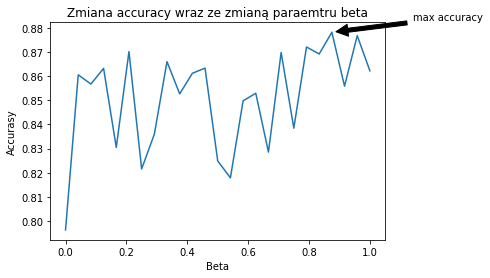

In [17]:
plt.figure()
plt.plot(all_posibility, beta_list)
plt.title("Zmiana accuracy wraz ze zmianą paraemtru beta")
plt.annotate('max accuracy', xy=(beta_max, max_accuracy), xytext=(lr_max + 1.1, max_accuracy + 0.005),
             arrowprops=dict(facecolor='black', shrink=0.05),)
plt.xlabel("Beta")
plt.ylabel("Accurasy")
plt.show()

In [18]:
print(beta_max)

0.875


Zatem zgodnie z ekeprymentami najlepszym wynikiem okazała się beta równy 0.875

In [19]:
regression.fit(ler_rate = 0.042, epoch = 10, beta = 0.125)
regression.predict(x_test)
pred = regression.predictions
acc = regression.evaluate(y_test,pred)
print(acc)

0.862143310082435


Wynik właściwie się nie różni. Widać na wykresie że accuracy jest bardzo podobne dla wartości beta = 0.875, jak również dla wartości bliskich 0.2. Wartość beta i learning rate mogę być ze sobą mocno skorelowane. Podczas eksperymentu szukajacego najlepszej wartości learning rate, beta była stale równa 0.9. Możliwe, że dla beta = 0.2, inna wartość learnig rate była by lepsza.

Siłowo możemy sprawdzić jakie najwięszke accuracy jesteśmy wstanie uzyskać manewrując wartościami learning rate i beta.


In [20]:
all_accuracy = []
for i in all_posibility:
    for j in all_posibility:
        regression.fit(ler_rate = j, epoch = 10, beta = i)
        regression.predict(x_test)
        pred = regression.predictions
        acc = regression.evaluate(y_test,pred)
        all_accuracy.append(acc)
      

Nie jest to najmądrzejszy sposób szukania optymalnych wartości parametrów, gdyby zbiór danych był dużo większy obliczenia byłby za długie. Jednak dla tego zbioru danych obliczenia wykonały się w długim, ale skończonym czasie.

In [21]:
print(max(all_accuracy))

0.8781230183893468


Na koniec wyświetlmy macierz błędu, precyzję oraz pełność.

In [22]:
regression.fit(epoch = 10)
regression.predict(x_test)
pred = regression.predictions
M = regression.confusion_matrix(y_test, pred)
precision = M[0][0]/(M[0][0] + M[1][0])
recall = M[0][0]/(M[0][0] + M[0][1])

print("Macierz błędu: ")
print(M)
print("Precyzja: ",precision)
print("Pełność: ",recall)


Macierz błędu: 
[[3424.  490.]
 [ 499. 3472.]]
Precyzja:  0.8728014274789702
Pełność:  0.8748083801737353


Jak widać, najlepsze accuracy nie różni sie wiele od tego z dobranymi odzielnie wartościami beta i learning rate. Co więcej accuracy jest równe dokładnie tyle ile wynosiło stosując standardowe parametry.

Podsumowując, bardzo interesujacy i zaskakujący jest fakt, że wartość learning rate odgrywa bardzo małą rolę w procesie uczenia. Może to wynikać z faktu, że algortym wykonuje bardzo dużo iteracji, dzięki czemu zawsze jest bardzo blisko minimum funckji. Ponadto opytmalizacja momentum, wa duży wpływ na zbieżność algorytmu, przez co learning rate może już nie odgrywać tak wielkiej roli, jak w przypadku zwykłego SGD.